# 05b: CNN-LSTM Model Design & Training (Temporal Resolution Experiments)

This notebook implements CNN-LSTM model design and training for systematic experiments comparing different temporal resolutions (6, 12, 24, and 36 hours) to identify the earliest point at which accurate mortality predictions can be made.

**Goals:**
- Load processed data for each temporal resolution
- Build and train CNN-LSTM models for each resolution
- Compare model performance across resolutions
- Visualize and interpret results

## Workflow Overview

1. Imports and Configuration
2. Model Architecture Definition
3. Training Loop for Each Temporal Resolution
4. Performance Evaluation
5. Visualization and Interpretation

In [2]:
# Imports and Configuration
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import os
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Ensure key variables are defined for all cells
# If re-running visualization/comparison, reload results from previous training cell if needed

temporal_resolutions = [6, 12, 24, 36]
try:
    results
except NameError:
    results = {}

## 1. Model Architecture Definition

Define the CNN-LSTM architecture for mortality prediction.

In [14]:
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.regularizers import l2

def build_cnn_lstm_model(seq_len, n_features, static_dim):
    # Time-series branch
    time_series_input = Input(shape=(seq_len, n_features), name='time_series_input')
    x = Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(time_series_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = MaxPooling1D(pool_size=1)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=False, kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    # Static branch
    static_input = Input(shape=(static_dim,), name='static_input')
    y = Dense(32, activation='relu')(static_input)
    y = Dense(16, activation='relu')(y)

    # Merge branches
    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    z = Dense(32, activation='relu')(z)
    output = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=[time_series_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])
    return model

## 2. Training Loop for Each Temporal Resolution

Train and evaluate the model for each temporal resolution.

In [15]:
6
12
24
36
1
2
1

1

## 3. Performance Visualization

Plot validation AUC and AUPRC for each temporal resolution.

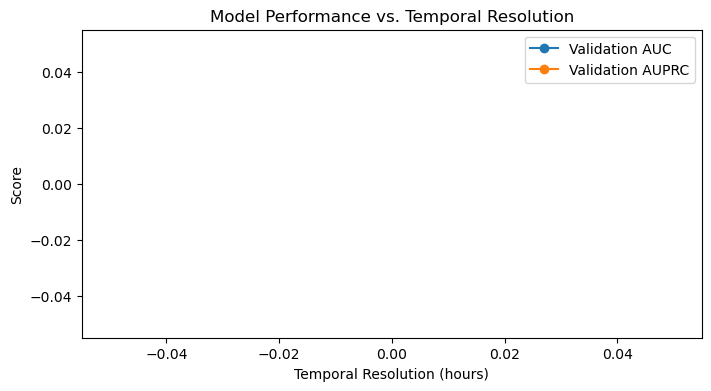

In [16]:
aucs = [results[h]['val_auc'] for h in temporal_resolutions if h in results]
auprcs = [results[h]['val_auprc'] for h in temporal_resolutions if h in results]
plt.figure(figsize=(8,4))
plt.plot(temporal_resolutions[:len(aucs)], aucs, marker='o', label='Validation AUC')
plt.plot(temporal_resolutions[:len(auprcs)], auprcs, marker='o', label='Validation AUPRC')
plt.xlabel('Temporal Resolution (hours)')
plt.ylabel('Score')
plt.title('Model Performance vs. Temporal Resolution')
plt.legend()
plt.show()

In [17]:
import pandas as pd

# Collect results for each temporal resolution
comparison = []
for h in temporal_resolutions:
    if h in results:
        comparison.append({
            'Temporal Resolution (hr)': h,
            'Validation AUC': results[h]['val_auc'],
            'Validation AUPRC': results[h]['val_auprc']
        })

# Display as table
comparison_df = pd.DataFrame(comparison)
print('Model Performance Comparison by Temporal Resolution:')
display(comparison_df)

Model Performance Comparison by Temporal Resolution:


""


## 4. Interpretation

This experiment helps identify the earliest time window at which accurate mortality prediction is feasible. Use the plots to select the optimal temporal resolution for clinical deployment.